# Project 3: Collaboration and Competition (Unity Tennis)

---
**Author: Jason Zeng**

**Date: April 25, 2020**

We will use Deep Deterministic Policy Gradient (DDPG) algorithm to train an muti-agent task Unity Tennis.

In this environment, two agents are controlling two rackets to play a Tennis game. If an agent hits the ball correctly, it will receive a reward of +0.1. If an agent misses the ball or it hits the ball out of bounds, it will receive a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation with a total of 24 states. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores. This yields a single score for each episode.

Due to the nature of multi-agent learning, the training period is quite noisy. In this experiment, we find after training both agents for ~2600 episodes, an average score of +0.55 over 100 consecutive episodes could be reached. This average score is after taking the maximum over both agents.


### 1. Start the Environment

First, let's install a few packages. This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. Train the Agents

This project is similar to the Continuous Control project, except we'll create and train the two agents independently. The back-bone method we will use to address continous action spaces is "Actor-Critic" DDPG algorithm. The details of DDPG algorithm can be found in [this paper](https://arxiv.org/abs/1509.02971).

In DDPG, “Actor” updates the policy distribution in the direction suggested by the "Critic" (such as with policy gradients), and the “Critic” estimates the value functions like action-value Q or state-value V. In this project, two agents will be trained independently. Each agent will receive its own states, rewards, and make its own actions. For this two-agent learning, both "Actor" and "Critic" will keep two networks: a local network to update training and a target network to evaluate results. Network weights can be "soft" updated by weighting local network parameters and target network parameters. For example, 0.01 of local network parameters and 0.999 of target network parameters.

Overview of NN structure:

- A two-hidden-layer NN for both "Actor" and "Critic".
- Layer 1 has 256 nodes and Layer 2 has 128 nodes.
- State size is 24.
- Two continuous actions: movement toward (or away from) the net, and jumping.
- Activation function ReLU is used in all layers.

Summary of key model parameters:
```python
BUFFER_SIZE = int(1e6) # replay buffer size
BATCH_SIZE = 128 # minibatch size
GAMMA = 0.98 # discount factor
TAU = 1e-3 # for soft update of target parameters
LR_ACTOR = 1e-4 # learning rate of the actor
LR_CRITIC = 1e-3 # learning rate of the critic
WEIGHT_DECAY = 0 # L2 weight decay
UPDATE_EVERY = 10 # how often to update the network
UPDATE_TIMES = 20 # how many times to update the network each time
EPSILON = 1.0 # epsilon for the noise process added to the actions
EPSILON_DECAY = 1e-6 # decay for epsilon above
```

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

# keep workstation alive
from workspace_utils import active_session

#### 4.1 Multi-agent DDPG, test run requiring mean score > 0.8

In [10]:
state_size=24
action_size=2
random_seed=1
threshold=0.8   # threshold to be tested

# agents
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

# define multi-agent DDPG
def maddpg(n_episodes=5000, reset_time=100, print_every=100, threshold=threshold):

    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent1.reset()
        agent2.reset()
        #for t in range(max_t):
        while True:
            action1 = agent1.act(np.expand_dims(states[0], axis=0))
            action2 = agent2.act(np.expand_dims(states[1], axis=0))
            actions = np.vstack((action1, action2))
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            score += rewards                                   # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)))
        # break when training reaches threshold
        if np.mean(scores_deque) > (threshold):
            print('\nEnvironment solved in {} episodes.\tAverage Score: {}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'agent1_checkpoint_actor_v1.pth')
            torch.save(agent1.critic_local.state_dict(), 'agent1_checkpoint_critic_v1.pth')
            torch.save(agent2.actor_local.state_dict(), 'agent2_checkpoint_actor_v1.pth')
            torch.save(agent2.critic_local.state_dict(), 'agent2_checkpoint_critic_v1.pth')
            break
            
    return scores

In [ ]:
with active_session():
    # do long-running work here
    scores = maddpg()

Episode 100	Average Score: -0.0009999998286366462
Episode 200	Average Score: 0.00100000020116567620
Episode 300	Average Score: 1.8626451492309571e-10
Episode 400	Average Score: 0.00850000031292438520
Episode 500	Average Score: 0.015000000409781934
Episode 600	Average Score: 0.011500000357627868
Episode 700	Average Score: 0.020500000491738327
Episode 800	Average Score: 0.020450000492855905
Episode 900	Average Score: 0.020500000491738328
Episode 1000	Average Score: 0.03200000066310167
Episode 1100	Average Score: 0.066000001179054396
Episode 1200	Average Score: 0.06695000119507313
Episode 1300	Average Score: 0.07200000126846134
Episode 1400	Average Score: 0.06800000119954347
Episode 1500	Average Score: 0.06600000117905439
Episode 1600	Average Score: 0.07000000122934588
Episode 1700	Average Score: 0.06395000114105642
Episode 1800	Average Score: 0.07295000128448009
Episode 1900	Average Score: 0.07950000137090683
Episode 2000	Average Score: 0.08550000146031384
Episode 2100	Average Score: 0.0

Somehow this kernel became dead after ~18 hours of training before it could solve with mean score > 0.8. I also used up all GPU hours provided by Udacity (50 hours in total). This makes it hard for me to rework on this problem using Workspace provided by Udacity. Anyway, a key point here is, roughly after 2600 Episodes, the environment can be solved if our goal is to obtain an average score > 0.5. The goal of achieving average score > 0.8 may be too hard to achieve. 

ALso, by observating the average score numbers together with Episode numbers, we can see the general trend, though with fluctuations, gradually increases over time. This indicates the agents learned how to react appropriately to environment.

If we plot the Score vs. Episode, we will get something like this plot below, which is for demnostration purpose only. 

In [20]:
import matplotlib

# define moving average function to be used in plotting
def moving_average(x, n=3) :
    ret = np.cumsum(x, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# plot score, together with moving average
def plot_scores(scores, smooth_window=30):
    scores_smoothed = moving_average(scores, smooth_window)
    # config the plot
    fig = plt.figure(figsize=(10, 8))
    matplotlib.rcParams.update({'font.size': 16})
    #ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, linewidth=2, alpha=0.4, color='green', label='individual')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='blue', label='average')
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)
    plt.ylabel('Score')
    plt.xlabel('Episode Number')
    plt.show()
    return fig

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return (checkpoint['actor'], checkpoint['critic'], checkpoint['scores'])

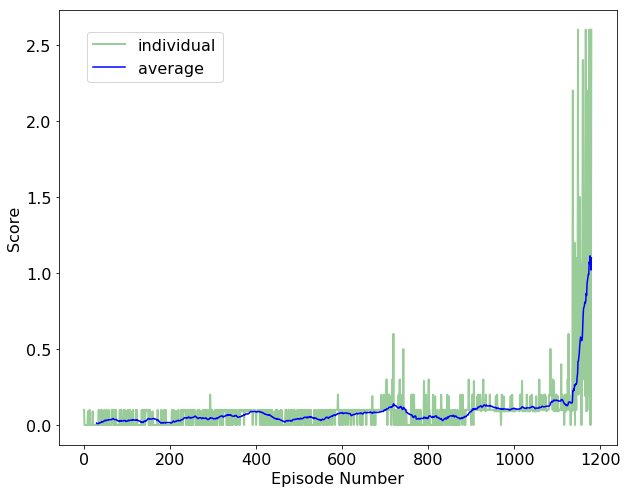

In [21]:
_, _, scores_solved = load_checkpoint('checkpoint-solved.pth')
figure = plot_scores(scores_solved)

### 5. Summary and Future Work

In this notebook, we applied Deep Deterministic Policy Gradient (DDPG) algorithm to train multi-agents for Unity Tennis task. 
An average score of 0.55 for 100 episodes is achieved with about 2600 training episodes.

A few ways to further improve:

- Hyperparameter tuning, including  ϵ -decay rate, discount factor, update frequency, drop out, batch size etc.
- Apply DDPG improvements, including PPO, Prioritized Experience Replay, A2C, AGE.
  - PPO: Proximal Policy Optimization algorithm
  - Prioritized Experience Replay: importance sampling of recycled trajectories
  - A2C: Advatage Actor Critic algorithm
  - AGE: Generalized Advantage Estimation algorithm